In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

2025-03-17 08:10:27.196135: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 08:10:27.197315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 08:10:27.200626: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 08:10:27.210535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742179227.229398    9098 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742179227.23

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vinyk-sd (vinyk-sd-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape data
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

In [4]:
class NeuralNetwork:
    def __init__(self, layers, activation=None, output_activation = 'softmax', weight_init=None):
        """
        Initializes the neural network.
        :param layers: List representing the number of neurons in each layer.
        :param activation: Activation function for hidden layers ('relu', 'sigmoid', 'tanh').
        :param output_activation: Activation function for the output layer ('softmax', 'sigmoid', or 'linear').
        :param weight_init: Weight initialization method ('random', 'xavier').
        """
        self.layers = layers
        self.activation = activation
        self.output_activation = output_activation  # Separate activation for output layer
        self.weight_init = weight_init
        self.weights, self.biases = self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights and biases based on the selected method."""
        np.random.seed(42)
        weights, biases = [], []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
                w = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            else:  # Default: Random small values
                w = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            
            b = np.zeros((1, self.layers[i+1]))
            weights.append(w)
            biases.append(b)
        
        return weights, biases

    def _activation(self, x, func, derivative=False):
        """Applies the selected activation function."""
        if func == "relu":
            return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)
        elif func == "tanh":
            t = np.tanh(x)
            return 1 - t**2 if derivative else t
        elif func == "sigmoid":
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig) if derivative else sig
        elif func == "softmax":
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        else:  # Linear (no activation)
            return x

    def forward(self, X):
        """Performs forward propagation."""
        activations, zs = [X], []

        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(activations[-1], w) + b
            zs.append(z)

            # Use different activation for last layer
            if i == len(self.weights) - 1:
                activations.append(self._activation(z, self.output_activation))
            else:
                activations.append(self._activation(z, self.activation))
        
        return activations, zs

    def backward(self, y_true, activations, zs, learning_rate):
        """Performs backpropagation and computes gradients."""
        grads_w, grads_b = [], []
        m = y_true.shape[0]
        
        # Compute loss gradient (assuming MSE loss for now)
        dA = activations[-1] - y_true  

        for i in reversed(range(len(self.weights))):
            activation_func = self.output_activation if i == len(self.weights) - 1 else self.activation
            dz = dA * self._activation(zs[i], activation_func, derivative=True)
            dw = np.dot(activations[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            dA = np.dot(dz, self.weights[i].T)

            grads_w.insert(0, dw)
            grads_b.insert(0, db)

        return grads_w, grads_b


In [5]:
# Optimizers
class Optimizer:
    def __init__(self, method= None, lr=None, beta=0.9, beta2=0.999, epsilon=1e-8):
        self.method = method
        self.lr = lr
        self.beta = beta  
        self.beta2 = beta2  
        self.epsilon = epsilon  
        self.m_w = None  
        self.v_w = None  
        self.m_b = None  
        self.v_b = None  
        self.t = 0  

    def update(self, weights, biases, grads_w, grads_b):
        if self.method == "sgd":
            weights = [w - self.lr * dw for w, dw in zip(weights, grads_w)]
            biases = [b - self.lr * db for b, db in zip(biases, grads_b)]

        elif self.method in ["momentum", "nesterov"]:
            if self.m_w is None:  
                self.m_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]

            for i in range(len(weights)):
                if self.method == "nesterov":
                    # Look-ahead step
                    look_ahead_w = weights[i] - self.beta * self.m_w[i]
                    look_ahead_b = biases[i] - self.beta * self.m_b[i]

                    
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]

                    weights[i] = look_ahead_w - self.m_w[i]
                    biases[i] = look_ahead_b - self.m_b[i]

                else:  
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]
                    weights[i] -= self.m_w[i]
                    biases[i] -= self.m_b[i]

        elif self.method in ["rmsprop", "adam", "nadam"]:
            if self.m_w is None: 
                self.m_w = [np.zeros_like(w) for w in weights]
                self.v_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]
                self.v_b = [np.zeros_like(b) for b in biases]

            self.t += 1  

            for i in range(len(weights)):
                if self.method == "rmsprop":
                    # Update second moment estimate (squared gradient)
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * grads_w[i] ** 2
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * grads_b[i] ** 2

                    # Update weights and biases
                    weights[i] -= self.lr * grads_w[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                    biases[i] -= self.lr * grads_b[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

                elif self.method in ["adam", "nadam"]:
                    # Compute biased first moment estimate
                    self.m_w[i] = self.beta * self.m_w[i] + (1 - self.beta) * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + (1 - self.beta) * grads_b[i]

                    # Compute biased second moment estimate
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)

                    # Bias correction
                    m_hat_w = self.m_w[i] / (1 - self.beta ** self.t)
                    v_hat_w = self.v_w[i] / (1 - self.beta2 ** self.t)
                    m_hat_b = self.m_b[i] / (1 - self.beta ** self.t)
                    v_hat_b = self.v_b[i] / (1 - self.beta2 ** self.t)

                    if self.method == "adam":
                        # Adam update rule
                        weights[i] -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

                    elif self.method == "nadam":
                        # Nadam additional momentum correction
                        nadam_m_w = self.beta * m_hat_w + (1 - self.beta) * grads_w[i] / (1 - self.beta ** self.t)
                        nadam_m_b = self.beta * m_hat_b + (1 - self.beta) * grads_b[i] / (1 - self.beta ** self.t)

                        weights[i] -= self.lr * nadam_m_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * nadam_m_b / (np.sqrt(v_hat_b) + self.epsilon)

        return weights, biases

In [13]:
def train():
    # Best hyperparameters
    params = {
        'epochs': 20,
        'batch_size': 32,
        'epsilon': 0.95,
        'optimizer': 'rmsprop',
        'learning_rate': 0.0001,
        'weight_decay': 0.5,
        'weight_init': "xavier",
        'hidden_layers': 5,
        'hidden_size': 128,
        'activation': 'tanh'
    }
    
    layers = [784] + [params['hidden_size']] * params['hidden_layers'] + [10]
    activation = params['activation']
    weight_init = params['weight_init']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    optimizer_type = params['optimizer']
    epochs = params['epochs']

    print(f"Training with: {params}")

    # Initialize Neural Network
    model = NeuralNetwork(layers, activation=activation, weight_init=weight_init)
    optimizer = Optimizer(method=optimizer_type, lr=learning_rate)

    for epoch in range(epochs):
        num_batches = len(X_train) // batch_size
        train_loss, train_acc = 0, 0

        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train_one_hot[start:end]

            # Forward propagation
            activations, zs = model.forward(X_batch)
            preds = np.argmax(activations[-1], axis=1)
            y_true_labels = np.argmax(y_batch, axis=1)

            # Compute loss and accuracy
            batch_loss = np.mean((activations[-1] - y_batch) ** 2)
            batch_acc = np.mean(preds == y_true_labels)

            train_loss += batch_loss
            train_acc += batch_acc

            # Backpropagation
            grads_w, grads_b = model.backward(y_batch, activations, zs, learning_rate)
            model.weights, model.biases = optimizer.update(model.weights, model.biases, grads_w, grads_b)

        # Average loss and accuracy
        train_loss /= num_batches
        train_acc /= num_batches

        # Validation phase
        val_activations, _ = model.forward(X_test)
        val_preds = np.argmax(val_activations[-1], axis=1)
        val_true_labels = np.argmax(y_test_one_hot, axis=1)

        val_loss = np.mean((val_activations[-1] - y_test_one_hot) ** 2)
        val_acc = np.mean(val_preds == val_true_labels)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    
    evaluate_and_plot_confusion_matrix(model, X_test, y_test_one_hot)

def evaluate_and_plot_confusion_matrix(model, X_test, y_test_one_hot):
    class_labels = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

    # Predict test set
    test_activations, _ = model.forward(X_test)
    y_pred = np.argmax(test_activations[-1], axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=class_labels, yticklabels=class_labels)
    
    plt.title("Confusion Matrix - Test Set")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}', 
                     ha='center', va='center', color='red')

    plt.show()

Training with: {'epochs': 20, 'batch_size': 32, 'epsilon': 0.95, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'weight_decay': 0.5, 'weight_init': 'xavier', 'hidden_layers': 5, 'hidden_size': 128, 'activation': 'tanh'}
Epoch 1: Train Loss=0.0256, Train Acc=0.8172, Val Loss=0.0227, Val Acc=0.8401
Epoch 2: Train Loss=0.0203, Train Acc=0.8567, Val Loss=0.0211, Val Acc=0.8516
Epoch 3: Train Loss=0.0189, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8594
Epoch 4: Train Loss=0.0181, Train Acc=0.8728, Val Loss=0.0197, Val Acc=0.8618
Epoch 5: Train Loss=0.0174, Train Acc=0.8772, Val Loss=0.0193, Val Acc=0.8641
Epoch 6: Train Loss=0.0169, Train Acc=0.8813, Val Loss=0.0191, Val Acc=0.8657
Epoch 7: Train Loss=0.0164, Train Acc=0.8850, Val Loss=0.0189, Val Acc=0.8678
Epoch 8: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0187, Val Acc=0.8681
Epoch 9: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0186, Val Acc=0.8696
Epoch 10: Train Loss=0.0153, Train Acc=0.8928, Val Loss=0.0184, Val Acc=0.87

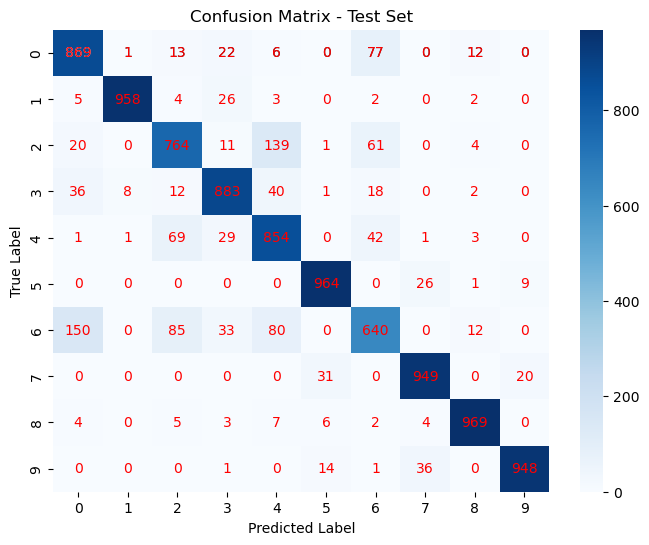

In [17]:
train()

In [18]:
def train_1():
    # Best hyperparameters
    params = {
        'epochs': 20,
        'batch_size': 32,
        'epsilon': 0.95,
        'optimizer': 'rmsprop',
        'learning_rate': 0.0001,
        'weight_decay': 0.5,
        'weight_init': "xavier",
        'hidden_layers': 5,
        'hidden_size': 128,
        'activation': 'tanh'
    }
    
    layers = [784] + [params['hidden_size']] * params['hidden_layers'] + [10]
    activation = params['activation']
    weight_init = params['weight_init']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    optimizer_type = params['optimizer']
    epochs = params['epochs']

    print(f"Training with: {params}")

    # Initialize Neural Network
    model = NeuralNetwork(layers, activation=activation, weight_init=weight_init)
    optimizer = Optimizer(method=optimizer_type, lr=learning_rate)

    for epoch in range(epochs):
        num_batches = len(X_train) // batch_size
        train_loss, train_acc = 0, 0

        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train_one_hot[start:end]

            # Forward propagation
            activations, zs = model.forward(X_batch)
            preds = np.argmax(activations[-1], axis=1)
            y_true_labels = np.argmax(y_batch, axis=1)

            # Compute loss and accuracy
            batch_loss = np.mean((activations[-1] - y_batch) ** 2)
            batch_acc = np.mean(preds == y_true_labels)

            train_loss += batch_loss
            train_acc += batch_acc

            # Backpropagation
            grads_w, grads_b = model.backward(y_batch, activations, zs, learning_rate)
            model.weights, model.biases = optimizer.update(model.weights, model.biases, grads_w, grads_b)

        # Average loss and accuracy
        train_loss /= num_batches
        train_acc /= num_batches

        # Validation phase
        val_activations, _ = model.forward(X_test)
        val_preds = np.argmax(val_activations[-1], axis=1)
        val_true_labels = np.argmax(y_test_one_hot, axis=1)

        val_loss = np.mean((val_activations[-1] - y_test_one_hot) ** 2)
        val_acc = np.mean(val_preds == val_true_labels)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


    evaluate_and_plot_confusion_matrix_1(model, X_test, y_test_one_hot)

def evaluate_and_plot_confusion_matrix_1(model, X_test, y_test_one_hot):
    class_labels = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]


    test_activations, _ = model.forward(X_test)
    y_pred = np.argmax(test_activations[-1], axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=class_labels, yticklabels=class_labels)
    
    plt.title("Confusion Matrix - Test Set")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")


    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}', 
                     ha='center', va='center', color='red')

    plt.show()

Training with: {'epochs': 20, 'batch_size': 32, 'epsilon': 0.95, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'weight_decay': 0.5, 'weight_init': 'xavier', 'hidden_layers': 5, 'hidden_size': 128, 'activation': 'tanh'}
Epoch 1: Train Loss=0.0256, Train Acc=0.8172, Val Loss=0.0227, Val Acc=0.8401
Epoch 2: Train Loss=0.0203, Train Acc=0.8567, Val Loss=0.0211, Val Acc=0.8516
Epoch 3: Train Loss=0.0189, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8594
Epoch 4: Train Loss=0.0181, Train Acc=0.8728, Val Loss=0.0197, Val Acc=0.8618
Epoch 5: Train Loss=0.0174, Train Acc=0.8772, Val Loss=0.0193, Val Acc=0.8641
Epoch 6: Train Loss=0.0169, Train Acc=0.8813, Val Loss=0.0191, Val Acc=0.8657
Epoch 7: Train Loss=0.0164, Train Acc=0.8850, Val Loss=0.0189, Val Acc=0.8678
Epoch 8: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0187, Val Acc=0.8681
Epoch 9: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0186, Val Acc=0.8696
Epoch 10: Train Loss=0.0153, Train Acc=0.8928, Val Loss=0.0184, Val Acc=0.87

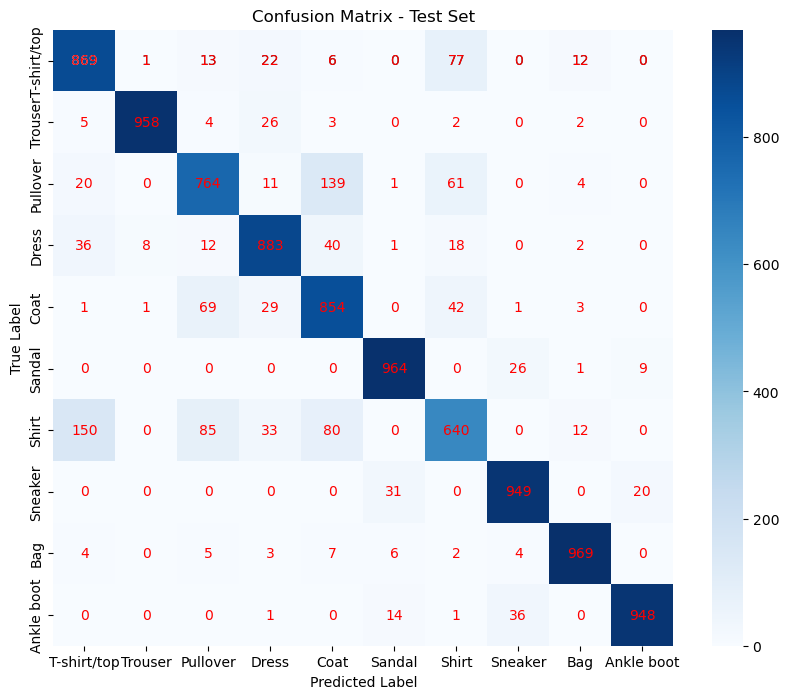

In [19]:
train_1()